In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [3]:
def apply_pca(X, standardize=True):
    
    # standardize data
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)   
    # create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # conver to dataframe
    component_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # create loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [4]:
df = pd.read_csv("C:../../Dataset/FECourseData/ames.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2930 non-null   object 
 1   MSZoning          2930 non-null   object 
 2   LotFrontage       2930 non-null   float64
 3   LotArea           2930 non-null   float64
 4   Street            2930 non-null   object 
 5   Alley             2930 non-null   object 
 6   LotShape          2930 non-null   object 
 7   LandContour       2930 non-null   object 
 8   Utilities         2930 non-null   object 
 9   LotConfig         2930 non-null   object 
 10  LandSlope         2930 non-null   object 
 11  Neighborhood      2930 non-null   object 
 12  Condition1        2930 non-null   object 
 13  Condition2        2930 non-null   object 
 14  BldgType          2930 non-null   object 
 15  HouseStyle        2930 non-null   object 
 16  OverallQual       2930 non-null   object 


In [6]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

In [7]:
print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [10]:

X = df.copy()
y = X.pop('SalePrice')
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)


                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


In [14]:
X_pca['PC1']

0      -0.165346
1      -0.639050
2      -0.794227
3       1.636658
4       0.293648
          ...   
2925   -0.276496
2926   -0.822084
2927   -1.730457
2928   -0.049130
2929    1.090406
Name: PC1, Length: 2930, dtype: float64

In [12]:
'''
X = df.copy()
y = X.pop("SalePrice")

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")
'''

# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

C:\Anaconda3\envs\tf_cpu\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Anaconda3\envs\tf_cpu\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Anaconda3\envs\tf_cpu\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Anaconda3\envs\tf_cpu\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Your score: 0.13707 RMSLE


C:\Anaconda3\envs\tf_cpu\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


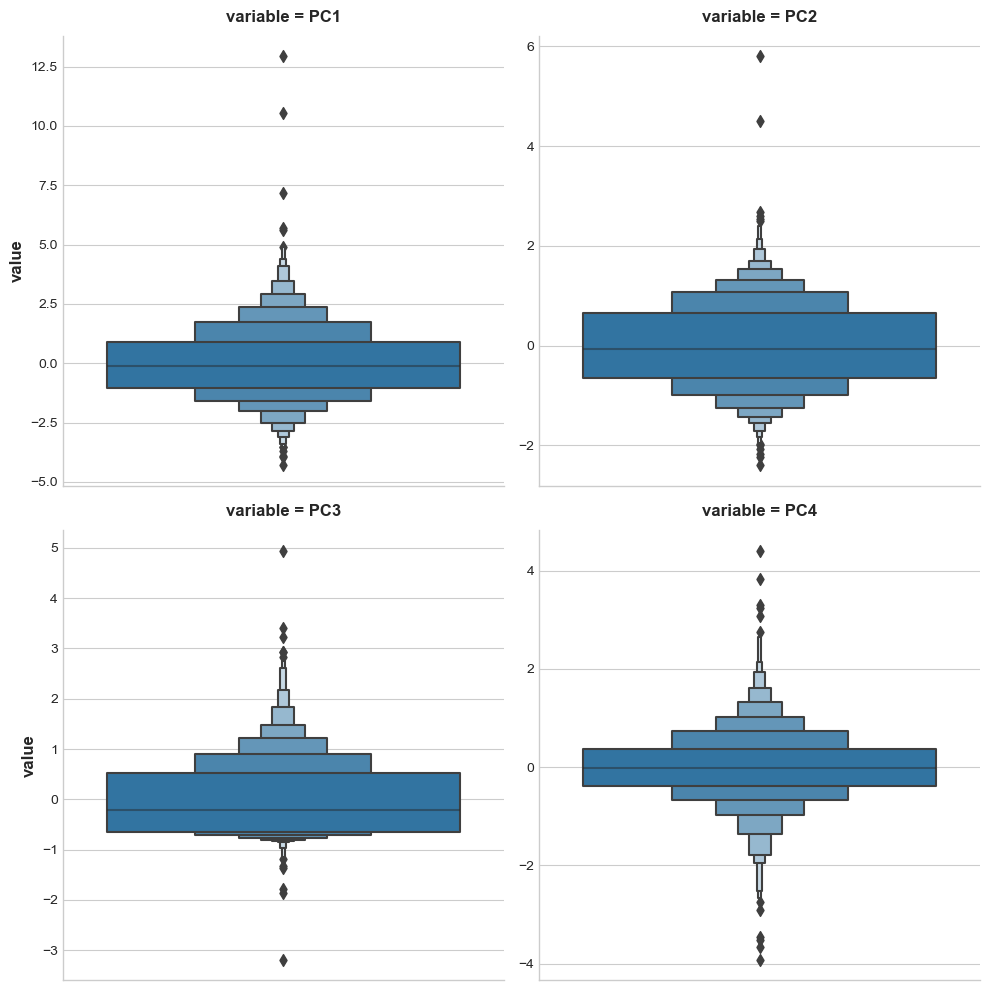

In [13]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [15]:
component = 'PC1'

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0
